ref: https://www.tensorflow.org/text/tutorials/transformer 

# Set Up

In [1]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

     |████████████████████████████████| 4.4 MB 7.7 MB/s 


In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

# Data Preparation

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteL1L6P5/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteL1L6P5/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteL1L6P5/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

# The Transformer Model

## Low Level

### Positional encoding
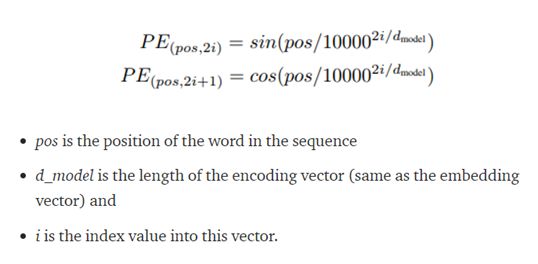

In [9]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [10]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

### Mask

In [11]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [12]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

### Scaled dot product attention

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### Multi-head attention

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

### Point wise feed forward network

In [15]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Middle Level

### Encoder layer

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

### Decoder layer

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

## High Level

### Encoder

In [18]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [19]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

### Transformer

In [20]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

# Training

## Hyperparameters

In [21]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [23]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Loss and metrics

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [25]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [27]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [29]:
EPOCHS = 20

In [30]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [31]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8809 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8105 Accuracy 0.0020
Epoch 1 Batch 100 Loss 8.7164 Accuracy 0.0194
Epoch 1 Batch 150 Loss 8.6045 Accuracy 0.0282
Epoch 1 Batch 200 Loss 8.4638 Accuracy 0.0321
Epoch 1 Batch 250 Loss 8.2936 Accuracy 0.0352
Epoch 1 Batch 300 Loss 8.1033 Accuracy 0.0374
Epoch 1 Batch 350 Loss 7.9061 Accuracy 0.0435
Epoch 1 Batch 400 Loss 7.7167 Accuracy 0.0535
Epoch 1 Batch 450 Loss 7.5473 Accuracy 0.0618
Epoch 1 Batch 500 Loss 7.3992 Accuracy 0.0694
Epoch 1 Batch 550 Loss 7.2647 Accuracy 0.0770
Epoch 1 Batch 600 Loss 7.1382 Accuracy 0.0850
Epoch 1 Batch 650 Loss 7.0221 Accuracy 0.0927
Epoch 1 Batch 700 Loss 6.9151 Accuracy 0.0997
Epoch 1 Batch 750 Loss 6.8147 Accuracy 0.1064
Epoch 1 Batch 800 Loss 6.7228 Accuracy 0.1125
Epoch 1 Loss 6.7059 Accuracy 0.1137
Time taken for 1 epoch: 107.40 secs

Epoch 2 Batch 0 Loss 5.3887 Accuracy 0.1876
Epoch 2 Batch 50 Loss 5.2457 Accuracy 0.2124
Epoch 2 Batch 100 Loss 5.2024 Accuracy 0.2180
Epoch 2 Batch